# Sentiment Analysis of Twitter posts
*Marcin Zabłocki*



## Abstract
The goal of this project was to predict sentiment for the given Twitter post using Python. Sentiment analysis can predict many different emotions attached to the text, but in this report only 3 major were considered: positive, negative and neutral. The training dataset was small (just over 5900 examples) and the data within it was highly skewed, which greatly impacted on the difficulty of building good classifier. After creating a lot of custom features, utilizing both bag-of-words and word2vec representations and applying the Extreme Gradient Boosting algorithm, the classification accuracy at level of 58% was achieved.


## Used Python Libraries
Data was pre-processed using *pandas*, *gensim* and *numpy* libraries and the learning/validating process was built with *scikit-learn*. Plots were created using *plotly*.

In [201]:
from collections import Counter
import nltk
import pandas as pd
from emoticons import EmoticonDetector
import re as regex
import numpy as np
import plotly
from plotly import graph_objs
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time
import gensim

# plotly configuration
plotly.offline.init_notebook_mode()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Notebook code convention
This report was first prepared as a classical Python project using object oriented programming with maintainability in mind. In order to show this project as a Jupyter Notebook, the classes had to be splitted into multiple code-cells. In order to do so, the classes are suffixed with *_PurposeOfThisSnippet* name and they inherit one from another. The final class will be then run and the results will be shown.

## Data source
The input data consisted two CSV files:
`train.csv` (5971 tweets) and `test.csv` (4000 tweets) - one for training and one for testing.
Format of the data was the following (test data didn't contain Category column):


| Id | Category  | Tweet |
|------|------|------|
|   635930169241374720  | neutral | IOS 9 App Transport Security. Mm need to check if my 3rd party network pod supports it |

All tweets are in english, so it simplifies the processing and analysis.


# Data preprocessing
## Loading the data
        

In [202]:
class TwitterData_Initialize():
    data = []
    processed_data = []
    wordlist = []

    data_model = None
    data_labels = None
    is_testing = False
    
    def initialize(self, csv_file, is_testing_set=False, from_cached=None):
        if from_cached is not None:
            self.data_model = pd.read_csv(from_cached)
            return

        self.is_testing = is_testing_set

        if not is_testing_set:
            self.data = pd.read_csv(csv_file, header=0, names=["id","comment", "emotion", "date","url"])
            self.data = self.data[self.data["emotion"].isin(["positive", "negative"])]
        else:
            self.data = pd.read_csv(csv_file, header=0, names=["id", "comment"],dtype={"id":"int64","text":"str"},nrows=4000)
            not_null_text = 1 ^ pd.isnull(self.data["comment"])
            not_null_id = 1 ^ pd.isnull(self.data["id"])
            self.data = self.data.loc[not_null_id & not_null_text, :]

        self.processed_data = self.data
        self.wordlist = []
        self.data_model = None
        self.data_labels = None

The code snippet above is prepared, to load the data form the given file for further processing, or just read already preprocessed file from the cache.
There's also a distinction between processing testing and training data. As the ```test.csv``` file was full of empty entries, they were removed.
Additional class properties such as data_model, wordlist etc. will be used further.

In [203]:
data = TwitterData_Initialize()
data.initialize("data\\four-column500v1.4.csv")
data.processed_data.head(5)

,id,comment,emotion,date,url
0,0,عسلامة أورونج رقدت مخلي ال puce متاعي أورونج ق...,negative,2018-01-02T19:16:17+0000,https://www.facebook.com/298166859034_10155976...
1,1,اورونج نحب نقلكم عيشكم خاتر انتوما الوحدين\nتت...,negative,2018-01-02T19:43:48+0000,https://www.facebook.com/298166859034_10155976...
2,2,"brabi orange, pk l'connexion ,ma@ t7ebech temc...",negative,2018-01-02T20:37:47+0000,https://www.facebook.com/298166859034_10155976...
3,3,slm orange elyoum 3adet fourfi 900 ta3 7 jour ...,negative,2018-01-02T19:00:49+0000,https://www.facebook.com/298166859034_10155976...
4,4,N7eb orange,positive,2018-01-08T20:13:49+0000,https://www.facebook.com/298166859034_10155991...


## Data distribution
First thing that can be done as soon as the data is loaded is to see the data distribution. The training set had the following distribution:


In [204]:
df = data.processed_data
neg = len(df[df["emotion"] == "negative"])
pos = len(df[df["emotion"] == "positive"])
#neu = len(df[df["emotion"] == "neutral"])
dist = [
    graph_objs.Bar(
        x=["negative","positive"],
        y=[neg, pos],
)]
#plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Sentiment type distribution in training set")})

## Preprocessing steps
The targed of the following preprocessing is to create a **Bag-of-Words** representation of the data. The steps will execute as follows:
1. Cleansing
<ol style="list-style-type:decimal"><li>Remove URLs</li>
<li>Remove usernames (mentions)</li>
<li>Remove tweets with *Not Available* text</li>
<li>Remove special characters</li>
<li>Remove numbers</li></ol>
1. Text processing
<ol style="list-style-type:decimal">
<li>Tokenize</li>
<li>Transform to lowercase</li>
<li>Stem</li></ol>
1. Build word list for Bag-of-Words

### Cleansing
For the purpose of cleansing, the ```TwitterCleanup``` class was created. It consists methods allowing to execute all of the tasks show in the list above. Most of those is done using regular expressions.
The class exposes it's interface through ```iterate()``` method - it yields every cleanup method in proper order.

In [205]:
class TwitterCleanuper:
    def iterate(self):
        for cleanup_method in [self.remove_urls,
                               self.remove_usernames,
                               self.remove_na,
                               self.remove_special_chars,
                               self.remove_numbers]:
            yield cleanup_method

    @staticmethod
    def remove_by_regex(tweets, regexp):
        tweets.loc[:, "comment"].replace(regexp, "", inplace=True)
        return tweets

    def remove_urls(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

    def remove_na(self, tweets):
        return tweets[tweets["comment"] != "Not Available"]

    def remove_special_chars(self, tweets):  # it unrolls the hashtags to normal words
        for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#"]):
            tweets.loc[:, "comment"].replace(remove, "", inplace=True)
        return tweets

    def remove_usernames(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

    def remove_numbers(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

The loaded tweets can be now cleaned. 

In [206]:
class TwitterData_Cleansing(TwitterData_Initialize):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def cleanup(self, cleanuper):
        t = self.processed_data
        for cleanup_method in cleanuper.iterate():
            if not self.is_testing:
                t = cleanup_method(t)
            else:
                if cleanup_method.__name__ != "remove_na":
                    t = cleanup_method(t)

        self.processed_data = t

In [207]:
data = TwitterData_Cleansing(data)
data.cleanup(TwitterCleanuper())
data.processed_data.head(5)

,id,comment,emotion,date,url
0,0,عسلامة أورونج رقدت مخلي ال puce متاعي أورونج ق...,negative,2018-01-02T19:16:17+0000,https://www.facebook.com/298166859034_10155976...
1,1,اورونج نحب نقلكم عيشكم خاتر انتوما الوحدين\nتت...,negative,2018-01-02T19:43:48+0000,https://www.facebook.com/298166859034_10155976...
2,2,brabi orange pk lconnexion ma tebech temchili ...,negative,2018-01-02T20:37:47+0000,https://www.facebook.com/298166859034_10155976...
3,3,slm orange elyoumadet fourfi ta jour tantli ma...,negative,2018-01-02T19:00:49+0000,https://www.facebook.com/298166859034_10155976...
4,4,Neb orange,positive,2018-01-08T20:13:49+0000,https://www.facebook.com/298166859034_10155991...


### Tokenization & stemming
For the text processing, ```nltk``` library is used. First, the tweets are tokenized using ```nlkt.word_tokenize``` and then, stemming is done using **PorterStemmer** as the tweets are 100% in english.


In [208]:
class TwitterData_TokenStem(TwitterData_Cleansing):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def stem(self, stemmer=nltk.PorterStemmer()):
        def stem_and_join(row):
            row["comment"] = list(map(lambda str: stemmer.stem(str.lower()), row["comment"]))
            return row

        self.processed_data = self.processed_data.apply(stem_and_join, axis=1)

    def tokenize(self, tokenizer=nltk.word_tokenize):
        def tokenize_row(row):
            row["comment"] = tokenizer(row["comment"])
            row["tokenized_text"] = [] + row["comment"]
            return row

        self.processed_data = self.processed_data.apply(tokenize_row, axis=1)


In [209]:
nltk.word_tokenize('في_بيتنا كل شي لما تحتاجه يضيع ...ادور على شاحن فجأة يختفي  ')

['في_بيتنا',
 'كل',
 'شي',
 'لما',
 'تحتاجه',
 'يضيع',
 '...',
 'ادور',
 'على',
 'شاحن',
 'فجأة',
 'يختفي']

In [210]:
data = TwitterData_TokenStem(data)
data.tokenize()
data.stem()
data.processed_data.head(5)

,id,comment,emotion,date,url,tokenized_text
0,0,"[عسلامة, أورونج, رقدت, مخلي, ال, puce, متاعي, ...",negative,2018-01-02T19:16:17+0000,https://www.facebook.com/298166859034_10155976...,"[عسلامة, أورونج, رقدت, مخلي, ال, puce, متاعي, ..."
1,1,"[اورونج, نحب, نقلكم, عيشكم, خاتر, انتوما, الوح...",negative,2018-01-02T19:43:48+0000,https://www.facebook.com/298166859034_10155976...,"[اورونج, نحب, نقلكم, عيشكم, خاتر, انتوما, الوح..."
2,2,"[brabi, orang, pk, lconnexion, ma, tebech, tem...",negative,2018-01-02T20:37:47+0000,https://www.facebook.com/298166859034_10155976...,"[brabi, orange, pk, lconnexion, ma, tebech, te..."
3,3,"[slm, orang, elyoumadet, fourfi, ta, jour, tan...",negative,2018-01-02T19:00:49+0000,https://www.facebook.com/298166859034_10155976...,"[slm, orange, elyoumadet, fourfi, ta, jour, ta..."
4,4,"[neb, orang]",positive,2018-01-08T20:13:49+0000,https://www.facebook.com/298166859034_10155991...,"[Neb, orange]"


### Building the wordlist
The wordlist (dictionary) is build by simple count of occurences of every unique word across all of the training dataset.

Before building the final wordlist for the model, let's take a look at the non-filtered version:


In [211]:
words = Counter()
for idx in data.processed_data.index:
    words.update(data.processed_data.loc[idx, "comment"])
words.most_common(5)

[('merci', 196), ('orang', 137), ('و', 72), ('في', 72), ('w', 63)]

The most commont words (as expected) are the typical english stopwords. We will filter them out, however, as purpose of this analysis is to determine sentiment, words like "not" and "n't" can influence it greatly. Having this in mind, this word will be whitelisted.


In [212]:
stopwords=nltk.corpus.stopwords.words("english")
whitelist = ["n't", "not"]
for idx, stop_word in enumerate(stopwords):
    if stop_word not in whitelist:
        del words[stop_word]
words.most_common(5)

[('merci', 196), ('orang', 137), ('و', 72), ('في', 72), ('w', 63)]

Still, there are some words that seem too be occuring to many times, let's filter them. After some analysis, the lower bound was set to 3.

The wordlist is also saved to the csv file, so the same words can be used for the testing set.


In [217]:
class TwitterData_Wordlist(TwitterData_TokenStem):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    whitelist = ["n't","not"]
    wordlist = []
        
    def build_wordlist(self, min_occurrences=3, max_occurences=500, stopwords=nltk.corpus.stopwords.words("english"),
                       whitelist=None):
        self.wordlist = []
        whitelist = self.whitelist if whitelist is None else whitelist
        import os
        if os.path.isfile("data\\wordlistv1.4.csv"):
            word_df = pd.read_csv("data\\wordlistv1.4.csv",encoding="latin-1")
            word_df = word_df[word_df["occurrences"] > min_occurrences]
            self.wordlist = list(word_df.loc[:, "word"])
            return

        words = Counter()
        for idx in self.processed_data.index:
            words.update(self.processed_data.loc[idx, "comment"])

        for idx, stop_word in enumerate(stopwords):
            if stop_word not in whitelist:
                del words[stop_word]

        word_df = pd.DataFrame(data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurences],
                                     "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurences]},
                               columns=["word", "occurrences"])

        word_df.to_csv("data\\wordlistv1.4.csv", index_label="idx")
        self.wordlist = [k for k, v in words.most_common() if min_occurrences < v < max_occurences]


In [218]:
data = TwitterData_Wordlist(data)
data.build_wordlist()

In [219]:
words = pd.read_csv("data\\wordlistv1.4.csv", encoding="latin-1")
x_words = list(words.loc[0:5,"word"])
x_words.reverse()
y_occ = list(words.loc[0:5,"occurrences"])
y_occ.reverse()

dist = [
    graph_objs.Bar(
        x=y_occ,
        y=x_words,
        orientation="h"
)]
#plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Top words in built wordlist")})

In [220]:
#import codecs
#with codecs.open("data\\wordlistv1.4.csv", "r",encoding='utf-8', errors='ignore') as fdata:

In [221]:
#with open("data\\wordlist.csv", encoding="latin-1") as datafile:
#words = pd.read_csv("data\\wordlistv1.4.csv", encoding="latin-1")

In [222]:
import matplotlib.pyplot as plt
%matplotlib inline

<Container object of 6 artists>

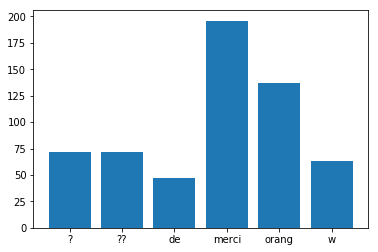

In [223]:
plt.bar(x_words,y_occ)

### Bag-of-words
The data is ready to transform it to bag-of-words representation.


In [226]:
class TwitterData_BagOfWords(TwitterData_Wordlist):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        self.wordlist = previous.wordlist
    
    def build_data_model(self):
        label_column = []
        if not self.is_testing:
            label_column = ["label"]

        columns = label_column + list(
            map(lambda w: w + ">",self.wordlist))
        labels = []
        rows = []
        for idx in self.processed_data.index:
            current_row = []

            if not self.is_testing:
                # add label
                current_label = self.processed_data.loc[idx, "emotion"]
                labels.append(current_label)
                current_row.append(current_label)

            # add bag-of-words
            tokens = set(self.processed_data.loc[idx, "comment"])
            for _, word in enumerate(self.wordlist):
                current_row.append(1 if word in tokens else 0)

            rows.append(current_row)

        self.data_model = pd.DataFrame(rows, columns=columns)
        self.data_labels = pd.Series(labels)
        return self.data_model, self.data_labels

Let's take a look at the data and see, which words are the most common for particular sentiments.

In [227]:
data = TwitterData_BagOfWords(data)
bow, labels = data.build_data_model()
bow.head(5)

,label,merci>,orang>,?>,??>,w>,de>,le>,??>,dima>,...,bonu>,????>,forfait>,lel>,????>,???>,oredoo>,ooredoo>,wala>,tunisi>
0,negative,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,negative,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,negative,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,negative,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,positive,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
grouped = bow.groupby(["label"]).sum()
words_to_visualize = []
sentiments = ["positive","negative"]
#get the most 7 common words for every sentiment
for sentiment in sentiments:
    words = grouped.loc[sentiment,:]
    words.sort_values(inplace=True,ascending=False)
    for w in words.index[:7]:
        if w not in words_to_visualize:
            words_to_visualize.append(w)
            
            
#visualize it
plot_data = []
for sentiment in sentiments:
    plot_data.append(graph_objs.Bar(
            x = [w.split("_")[0] for w in words_to_visualize],
            y = [grouped.loc[sentiment,w] for w in words_to_visualize],
            name = sentiment
    ))

In [231]:
import plotly as py
py.tools.set_credentials_file(username='samirromdhani', api_key='ia0qpy717g')

In [232]:
import plotly.plotly as py
import plotly.tools as plotly_tools
from plotly.graph_objs import *

Some of the most common words show high distinction between classes like *go* and *see* and other are occuring in similiar amount for every class (*plan*, *obama*).

None of the most common words is unique to the negative class. At this point, it's clear that skewed data distribution will be a problem in distinguishing negative tweets from the others. 

# Classification
First of all, lets establish seed for random numbers generators.

In [233]:
import random
seed = 666
random.seed(seed)

The following utility function will train the classifier and show the F1, precision, recall and accuracy scores.

In [234]:
def test_classifier(X_train, y_train, X_test, y_test, classifier):
    log("")
    log("===============================================")
    classifier_name = str(type(classifier).__name__)
    log("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    log("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    log("Predicting time {0}s".format(time() - now))

    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    log("=================== Results ===================")
    log("            Negative     Neutral     Positive")
    log("F1       " + str(f1))
    log("Precision" + str(precision))
    log("Recall   " + str(recall))
    log("Accuracy " + str(accuracy))
    log("===============================================")

    return precision, recall, accuracy, f1

def log(x):
    #can be used to write to log file
    print(x)

## Experiment 1: BOW + Naive Bayes
It is nice to see what kind of results we might get from such simple model. The bag-of-words representation is binary, so Naive Bayes Classifier seems like a nice algorithm to start the experiments.

The experiment will be based on ```7:3``` train:test stratified split.



In [235]:
from sklearn.naive_bayes import BernoulliNB
X_train, X_test, y_train, y_test = train_test_split(bow.iloc[:, 1:], bow.iloc[:, 0],
                                                    train_size=0.7, stratify=bow.iloc[:, 0],
                                                    random_state=seed)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, BernoulliNB())

C:\Anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.




Testing BernoulliNB
Learing time 0.23858642578125s
Predicting time 0.060396671295166016s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.44444444 0.64480874]
Precision[0.68421053 0.52678571]
Recall   [0.32911392 0.83098592]
Accuracy 0.5666666666666667


In [244]:
X_train[:5]
len(X_train)

349

In [248]:
y_train[:5]

392    positive
424    negative
140    positive
231    positive
36     negative
Name: label, dtype: object

In [249]:
X_test[:5]
len(X_test)

150

In [250]:
y_test[:5]

452    negative
125    positive
418    negative
56     positive
2      negative
Name: label, dtype: object

Result with accuracy at level of 58% seems to be quite nice result for such basic algorithm like Naive Bayes (having in mind that random classifier would yield result of around 33% accuracy). This performance may not hold for the final testing set. In order to see how the NaiveBayes performs in more general cases, 8-fold crossvalidation is used. The 8 fold is used, to optimize speed of testing on my 8-core machine.


In [251]:
def cv(classifier, X_train, y_train):
    log("===============================================")
    classifier_name = str(type(classifier).__name__)
    now = time()
    log("Crossvalidating " + classifier_name + "...")
    accuracy = [cross_val_score(classifier, X_train, y_train, cv=8, n_jobs=-1)]
    log("Crosvalidation completed in {0}s".format(time() - now))
    log("Accuracy: " + str(accuracy[0]))
    log("Average accuracy: " + str(np.array(accuracy[0]).mean()))
    log("===============================================")
    return accuracy

In [252]:
nb_acc = cv(BernoulliNB(), bow.iloc[:,1:], bow.iloc[:,0])

Crossvalidating BernoulliNB...
Crosvalidation completed in 5.636639356613159s
Accuracy: [0.46031746 0.52380952 0.50793651 0.49206349 0.53968254 0.5483871
 0.59016393 0.60655738]
Average accuracy: 0.5336147415073909


This result no longer looks optimistic. For some of the splits, Naive Bayes classifier showed performance below the performance of random classifier.

## Additional features
In order to **not** push any other aglorithm to the limit on the current data model, let's try to add some features that might help to classify tweets.

A common sense suggest that special characters like exclamation marks and the casing might be important in the task of determining the sentiment.
The following features will be added to the data model:

| Feature name | Explanation |
|------|------|
|Number of uppercase | people tend to express with either positive or negative emotions by using A LOT OF UPPERCASE WORDS |
| Number of ! | exclamation marks are likely to increase the strength of opinion |
| Number of ? | might distinguish neutral tweets - seeking for information |
| Number of positive emoticons | positive emoji will most likely not occur in the negative tweets|
| Number of negative emoticons | inverse to the one above |
| Number of ... | commonly used in commenting something |
| Number of quotations | same as above | 
| Number of mentions | sometimes people put a lot of mentions on positive tweets, to share something good |
| Number of hashtags | just for the experiment |
| Number of urls | similiar to the number of mentions |

Extraction of those features must be done before any preprocessing happens.

For the purpose of emoticons, the ```EmoticonDetector``` class is created. The file ```emoticons.txt``` contains list of positive and negative emoticons, which are used.

In [24]:
class EmoticonDetector:
    emoticons = {}

    def __init__(self, emoticon_file="data\\emoticons.txt"):
        from pathlib import Path
        content = Path(emoticon_file).read_text()
        positive = True
        for line in content.split("\n"):
            if "positive" in line.lower():
                positive = True
                continue
            elif "negative" in line.lower():
                positive = False
                continue

            self.emoticons[line] = positive

    def is_positive(self, emoticon):
        if emoticon in self.emoticons:
            return self.emoticons[emoticon]
        return False

    def is_emoticon(self, to_check):
        return to_check in self.emoticons

In [25]:
class TwitterData_ExtraFeatures(TwitterData_Wordlist):
    def __init__(self):
        pass
    
    def build_data_model(self):
        extra_columns = [col for col in self.processed_data.columns if col.startswith("number_of")]
        label_column = []
        if not self.is_testing:
            label_column = ["label"]

        columns = label_column + extra_columns + list(
            map(lambda w: w + "_bow",self.wordlist))
        
        labels = []
        rows = []
        for idx in self.processed_data.index:
            current_row = []

            if not self.is_testing:
                # add label
                current_label = self.processed_data.loc[idx, "emotion"]
                labels.append(current_label)
                current_row.append(current_label)

            for _, col in enumerate(extra_columns):
                current_row.append(self.processed_data.loc[idx, col])

            # add bag-of-words
            tokens = set(self.processed_data.loc[idx, "text"])
            for _, word in enumerate(self.wordlist):
                current_row.append(1 if word in tokens else 0)

            rows.append(current_row)

        self.data_model = pd.DataFrame(rows, columns=columns)
        self.data_labels = pd.Series(labels)
        return self.data_model, self.data_labels
    
    def build_features(self):
        def count_by_lambda(expression, word_array):
            return len(list(filter(expression, word_array)))

        def count_occurences(character, word_array):
            counter = 0
            for j, word in enumerate(word_array):
                for char in word:
                    if char == character:
                        counter += 1

            return counter

        def count_by_regex(regex, plain_text):
            return len(regex.findall(plain_text))

        self.add_column("splitted_text", map(lambda txt: txt.split(" "), self.processed_data["text"]))

        # number of uppercase words
        uppercase = list(map(lambda txt: count_by_lambda(lambda word: word == word.upper(), txt),
                             self.processed_data["splitted_text"]))
        self.add_column("number_of_uppercase", uppercase)

        # number of !
        exclamations = list(map(lambda txt: count_occurences("!", txt),
                                self.processed_data["splitted_text"]))

        self.add_column("number_of_exclamation", exclamations)

        # number of ?
        questions = list(map(lambda txt: count_occurences("?", txt),
                             self.processed_data["splitted_text"]))

        self.add_column("number_of_question", questions)

        # number of ...
        ellipsis = list(map(lambda txt: count_by_regex(regex.compile(r"\.\s?\.\s?\."), txt),
                            self.processed_data["text"]))

        self.add_column("number_of_ellipsis", ellipsis)

        # number of hashtags
        hashtags = list(map(lambda txt: count_occurences("#", txt),
                            self.processed_data["splitted_text"]))

        self.add_column("number_of_hashtags", hashtags)

        # number of mentions
        mentions = list(map(lambda txt: count_occurences("@", txt),
                            self.processed_data["splitted_text"]))

        self.add_column("number_of_mentions", mentions)

        # number of quotes
        quotes = list(map(lambda plain_text: int(count_occurences("'", [plain_text.strip("'").strip('"')]) / 2 +
                                                 count_occurences('"', [plain_text.strip("'").strip('"')]) / 2),
                          self.processed_data["text"]))

        self.add_column("number_of_quotes", quotes)

        # number of urls
        urls = list(map(lambda txt: count_by_regex(regex.compile(r"http.?://[^\s]+[\s]?"), txt),
                        self.processed_data["text"]))

        self.add_column("number_of_urls", urls)

        # number of positive emoticons
        ed = EmoticonDetector()
        positive_emo = list(
            map(lambda txt: count_by_lambda(lambda word: ed.is_emoticon(word) and ed.is_positive(word), txt),
                self.processed_data["splitted_text"]))

        self.add_column("number_of_positive_emo", positive_emo)

        # number of negative emoticons
        negative_emo = list(map(
            lambda txt: count_by_lambda(lambda word: ed.is_emoticon(word) and not ed.is_positive(word), txt),
            self.processed_data["splitted_text"]))

        self.add_column("number_of_negative_emo", negative_emo)
        
    def add_column(self, column_name, column_content):
        self.processed_data.loc[:, column_name] = pd.Series(column_content, index=self.processed_data.index)


In [26]:
data = TwitterData_ExtraFeatures()
data.initialize("data\\train.csv")
data.build_features()
data.cleanup(TwitterCleanuper())
data.tokenize()
data.stem()
data.build_wordlist()
data_model, labels = data.build_data_model()
data_model.head(5)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\generic.py:3443: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,label,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis,number_of_hashtags,number_of_mentions,number_of_quotes,number_of_urls,number_of_positive_emo,...,topless_bow,flop_bow,scari_bow,attract_bow,pr_bow,sne_bow,harder_bow,sole_bow,rafe_bow,nc_bow
0,neutral,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,neutral,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,negative,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,positive,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,neutral,4,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Logic behind extra features
Let's see how (some) of the extra features separate the data set. Some of them, i.e number exclamation marks, number of pos/neg emoticons do this really well. Despite of the good separation, those features sometimes occur only on small subset of the training dataset.

In [27]:
sentiments = ["positive","negative","neutral"]
plots_data_ef = []
for what in map(lambda o: "number_of_"+o,["positive_emo","negative_emo","exclamation","hashtags","question"]):
    ef_grouped = data_model[data_model[what]>=1].groupby(["label"]).count()
    plots_data_ef.append({"data":[graph_objs.Bar(
            x = sentiments,
            y = [ef_grouped.loc[s,:][0] for s in sentiments],
    )], "title":"How feature \""+what+"\" separates the tweets"})
    

for plot_data_ef in plots_data_ef:
    plotly.offline.iplot({
            "data":plot_data_ef["data"],
            "layout":graph_objs.Layout(title=plot_data_ef["title"])
    })


## Experiment 2: extended features + Random Forest
As a second attempt on the classification the **Random Forest** will be used.

In [28]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(data_model.iloc[:, 1:], data_model.iloc[:, 0],
                                                    train_size=0.7, stratify=data_model.iloc[:, 0],
                                                    random_state=seed)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, RandomForestClassifier(random_state=seed,n_estimators=403,n_jobs=-1))


Testing RandomForestClassifier
Learing time 6.9144287109375s
Predicting time 0.21802711486816406s
=================== Results ===================
            Negative     Neutral     Positive
F1       [ 0.24501425  0.47944007  0.70340909]
Precision[ 0.47777778  0.49192101  0.63163265]
Recall   [ 0.16475096  0.46757679  0.79358974]
Accuracy 0.575291948371


The accuracy for the initial split was lower than the one for the Naive Bayes, but let's see what happens during crossvalidation:


In [29]:
rf_acc = cv(RandomForestClassifier(n_estimators=403,n_jobs=-1, random_state=seed),data_model.iloc[:, 1:], data_model.iloc[:, 0])

Crossvalidating RandomForestClassifier...
Crosvalidation completed in 70.09595036506653s
Accuracy: [ 0.54344624  0.50442478  0.37905605  0.27876106  0.37905605  0.52141802
  0.5155096   0.55621302]
Average accuracy: 0.459735602399


It looks better, however it's still not much above accuracy of the random classifier and barely better than Naive Bayes classifier.

We can observe a low recall level of the RandomForest classifier for the negative class, which may be caused by the data skewness.

## More features - word2vec
The overall performance of the previous classifiers could be enhanced by performing time-consuming parameters adjustments, however there's not guarantee on how big the gain will be.

If the out-of-the-shelf methods did not performed well, it seems that there's not much in the data itself. The next idea to add more into data model is to use word2vec representation of a tweet to perform classification. 

The word2vec allows to transform words into vectors of numbers. Those vectors represent abstract features, that describe the word similarities and relationships (i.e co-occurence).

What is the best in the word2vec is that operations on the vectors approximately keep the characteristics of the words, so that joining (averaging) vectors from the words from sentence procude vector that is likely to represent the general topic of the sentence.

A lot of pre-trained word2vec models exists, and some of them were trained on huge volumes of data. For the purpose of this analysis, the one trained on over **2 billion of tweets** with 200 dimensions (one vector consists of 200 numbers) is used.
The pre-trained model can be downloaded here: https://github.com/3Top/word2vec-api


### From GloVe to word2vec
In order to use GloVe-trained model in ```gensim``` library, it needs to be converted to word2vec format. The only difference between those formats is that word2vec text files starts with two numbers: *number of lines in file* and *number of dimensions*. The file ```glove.twitter.27B.200d.txt``` does not contain those lines.

Unfortunaltely, this text file size is over 1.9GB and text editors cannot be used to open and modify it in reasonable amount of time, this **C#** snippet adds this required line (sorry that it's not Python, but I was having memory problems with encoding of the file in Python. It's required to use x64 target):
```{Csharp}
using (var fileStream = new FileStream("glove.twitter.27B.200d.txt", FileMode.Open,FileAccess.ReadWrite))
{
    var lines = new LinkedList<string>();
    using (var streamReader = new StreamReader(fileStream))
    {
        while (!streamReader.EndOfStream)
        {
            lines.AddLast(streamReader.ReadLine());
        }
    }
    lines.AddFirst("1193514 200");
    File.WriteAllLines("word2vec.twitter.27B.200d.txt.txt", lines);
}
```

#### Already modified GloVe for file
The file that has the first line appended can be downloaded from here (622MB 7-zip file, ultra compression): https://marcin.egnyte.com/dl/gk9nRsVMMY

### Using Word2Vec
The following class exposes a easy to use interface over the word2vec API from ```gensim``` library:



In [30]:
class Word2VecProvider(object):
    word2vec = None
    dimensions = 0

    def load(self, path_to_word2vec):
        self.word2vec = gensim.models.Word2Vec.load_word2vec_format(path_to_word2vec, binary=False)
        self.word2vec.init_sims(replace=True)
        self.dimensions = self.word2vec.vector_size

    def get_vector(self, word):
        if word not in self.word2vec.vocab:
            return None

        return self.word2vec.syn0norm[self.word2vec.vocab[word].index]

    def get_similarity(self, word1, word2):
        if word1 not in self.word2vec.vocab or word2 not in self.word2vec.vocab:
            return None

        return self.word2vec.similarity(word1, word2)

In [31]:
word2vec = Word2VecProvider()

# REPLACE PATH TO THE FILE
word2vec.load("C:\\__\\machinelearning\\glove.twitter.27B.200d.txt")

### Extra features from word2vec
Besides the 200 additional features from the word2vec representation, I had an idea of 3 more features. If word2vec allows to find similarity between words, that means it can find similarity to the specific emotion-representing words. The first idea was to compute similarity of the whole tweet with words from labels: *positive, negative, neutral*. Since the purpose was to find the sentiment, I thought that it will be better to find similarity with more expressive words such as: **good** and **bad**. For the neutral sentiment, I've used word **information**, since most of the tweets with neutral sentiment were giving the information.

The features were builded by computing **mean similarity of the whole tweet to the given word**. Then, those mean values were normalized to [0;1] in order to deal with different word count across tweets.

## Final data model
The final data model will contain:
* extra text features (number of: !, ?, :-) etc)
* word2vec similarity to "good", "bad" and "information" words
* word2vec 200 dimension averaged representation of a tweet
* bag-of-word representation of a tweet


In [32]:
class TwitterData(TwitterData_ExtraFeatures):
    
    def build_final_model(self, word2vec_provider, stopwords=nltk.corpus.stopwords.words("english")):
        whitelist = self.whitelist
        stopwords = list(filter(lambda sw: sw not in whitelist, stopwords))
        extra_columns = [col for col in self.processed_data.columns if col.startswith("number_of")]
        similarity_columns = ["bad_similarity", "good_similarity", "information_similarity"]
        label_column = []
        if not self.is_testing:
            label_column = ["label"]

        columns = label_column + ["original_id"] + extra_columns + similarity_columns + list(
            map(lambda i: "word2vec_{0}".format(i), range(0, word2vec_provider.dimensions))) + list(
            map(lambda w: w + "_bow",self.wordlist))
        labels = []
        rows = []
        for idx in self.processed_data.index:
            current_row = []

            if not self.is_testing:
                # add label
                current_label = self.processed_data.loc[idx, "emotion"]
                labels.append(current_label)
                current_row.append(current_label)

            current_row.append(self.processed_data.loc[idx, "id"])

            for _, col in enumerate(extra_columns):
                current_row.append(self.processed_data.loc[idx, col])

            # average similarities with words
            tokens = self.processed_data.loc[idx, "tokenized_text"]
            for main_word in map(lambda w: w.split("_")[0], similarity_columns):
                current_similarities = [abs(sim) for sim in
                                        map(lambda word: word2vec_provider.get_similarity(main_word, word.lower()), tokens) if
                                        sim is not None]
                if len(current_similarities) <= 1:
                    current_row.append(0 if len(current_similarities) == 0 else current_similarities[0])
                    continue
                max_sim = max(current_similarities)
                min_sim = min(current_similarities)
                current_similarities = [((sim - min_sim) / (max_sim - min_sim)) for sim in
                                        current_similarities]  # normalize to <0;1>
                current_row.append(np.array(current_similarities).mean())

            # add word2vec vector
            tokens = self.processed_data.loc[idx, "tokenized_text"]
            current_word2vec = []
            for _, word in enumerate(tokens):
                vec = word2vec_provider.get_vector(word.lower())
                if vec is not None:
                    current_word2vec.append(vec)

            averaged_word2vec = list(np.array(current_word2vec).mean(axis=0))
            current_row += averaged_word2vec

            # add bag-of-words
            tokens = set(self.processed_data.loc[idx, "text"])
            for _, word in enumerate(self.wordlist):
                current_row.append(1 if word in tokens else 0)

            rows.append(current_row)

        self.data_model = pd.DataFrame(rows, columns=columns)
        self.data_labels = pd.Series(labels)
        return self.data_model, self.data_labels

In [33]:
td = TwitterData()
td.initialize("data\\train.csv")
td.build_features()
td.cleanup(TwitterCleanuper())
td.tokenize()
td.stem()
td.build_wordlist()
td.build_final_model(word2vec)

td.data_model.head(5)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\generic.py:3443: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,label,original_id,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis,number_of_hashtags,number_of_mentions,number_of_quotes,number_of_urls,...,topless_bow,flop_bow,scari_bow,attract_bow,pr_bow,sne_bow,harder_bow,sole_bow,rafe_bow,nc_bow
0,neutral,635930169241374720,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,neutral,635950258682523648,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,negative,636030803433009153,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,positive,636100906224848896,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,neutral,636176272947744772,4,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [34]:
data_model = td.data_model
data_model.drop("original_id",axis=1,inplace=True)


### Logic behind word2vec extra features
In order to show, why the 3 extra features built using word2vec might help in sentiment analysis. The chart below shows how many tweets from given category were dominating (had highest value) on similarity to those words.
Although the words doesn't seem to separate the sentiments themselves, the differences between them in addition to other parameters, may help the classification process - i.e when tweet has highest value on *good_similarity* it's more likely for it to be classified to have positive sentiment.


In [35]:
columns_to_plot = ["bad_similarity", "good_similarity", "information_similarity"]
bad, good, info = columns_to_plot
sentiments = ["positive","negative","neutral"]
only_positive = data_model[data_model[good]>=data_model[bad]]
only_positive = only_positive[only_positive[good]>=only_positive[info]].groupby(["label"]).count()

only_negative = data_model[data_model[bad] >= data_model[good]]
only_negative = only_negative[only_negative[bad] >= only_negative[info]].groupby(["label"]).count()

only_info = data_model[data_model[info]>=data_model[good]]
only_info = only_info[only_info[info]>=only_info[bad]].groupby(["label"]).count()

plot_data_w2v = []
for sentiment in sentiments:
    plot_data_w2v.append(graph_objs.Bar(
            x = ["good","bad", "information"],
            y = [only_positive.loc[sentiment,:][0], only_negative.loc[sentiment,:][0], only_info.loc[sentiment,:][0]],
            name = "Number of dominating " + sentiment
    ))
    
plotly.offline.iplot({
        "data":plot_data_w2v,
        "layout":graph_objs.Layout(title="Number of tweets dominating on similarity to: good, bad, information")
    })

## Experiment 3: full model + Random Forest
The model is now complete. With a lot of new features, the learning algorithms should perform totally differently on the new data set.


In [36]:
X_train, X_test, y_train, y_test = train_test_split(data_model.iloc[:, 1:], data_model.iloc[:, 0],
                                                    train_size=0.7, stratify=data_model.iloc[:, 0],
                                                    random_state=seed)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, RandomForestClassifier(n_estimators=403,n_jobs=-1, random_state=seed))
rf_acc = cv(RandomForestClassifier(n_estimators=403,n_jobs=-1,random_state=seed),data_model.iloc[:, 1:], data_model.iloc[:, 0])


Testing RandomForestClassifier
Learing time 3.579137086868286s
Predicting time 0.2350320816040039s
=================== Results ===================
            Negative     Neutral     Positive
F1       [ 0.08695652  0.48138056  0.72029835]
Precision[ 0.8         0.51456311  0.61622607]
Recall   [ 0.04597701  0.45221843  0.86666667]
Accuracy 0.585740626921
Crossvalidating RandomForestClassifier...
Crosvalidation completed in 41.57810711860657s
Accuracy: [ 0.58468336  0.52654867  0.54129794  0.54867257  0.51622419  0.5465288
  0.58493353  0.56508876]
Average accuracy: 0.551747226492


As we can see, the average accuracy from crossvalidation is almost 58%, and the results from the crossvalidation runs are more stable - they never drop below 51%. It might seem that the algorithm will perform pretty well on the testing set. There's a one problem with that - recall for the 7:3 split shows, that only about 3% of the negative tweets from the whole set were recognized properly - it seems like the algorithm is good with recognition of postive vs. neutral cases, but it does really poor job when it comes to recognize negative sentiment. Let's try something else.

## Experiment 4: full model + XGBoost
XGBoost is relatively new machine learning algorithm based on decision trees and boosting. It is highly scalable and provides results, which are often higher than those obtained using popular algorithms such as Random Forest or SVM.

**Important**: XGBoost exposes scikit-learn interface, but it needs to be installed as an additional python package. See this page to see more: https://xgboost.readthedocs.io/en/latest/build.html



In [37]:
from xgboost import XGBClassifier as XGBoostClassifier

In [38]:

X_train, X_test, y_train, y_test = train_test_split(data_model.iloc[:, 1:], data_model.iloc[:, 0],
                                                    train_size=0.7, stratify=data_model.iloc[:, 0],
                                                    random_state=seed)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, XGBoostClassifier(seed=seed))


Testing XGBClassifier
Learing time 94.12349128723145s
Predicting time 0.2379899024963379s
=================== Results ===================
            Negative     Neutral     Positive
F1       [ 0.33595801  0.50823938  0.72674419]
Precision[ 0.53333333  0.51675485  0.66489362]
Recall   [ 0.24521073  0.5         0.80128205]
Accuracy 0.60356484327


60% accuracy is the highest result yet. Still, it's only a result on the splitted training set, let's see what happens when we crossvalidate this algorithm (with default parameters).

In [39]:
xgb_acc = cv(XGBoostClassifier(seed=seed),data_model.iloc[:, 1:], data_model.iloc[:, 0])

Crossvalidating XGBClassifier...
Crosvalidation completed in 335.4184989929199s
Accuracy: [ 0.62592047  0.53834808  0.50737463  0.47492625  0.42182891  0.53471196
  0.56277696  0.54585799]
Average accuracy: 0.526468157158


Averaged accuracy seems to be lower and less stable than for the Random Forest, but given over 8 times better recall for the negative cases, the XGBoost seems to be a good starting point for the final classifier.

### Finding best parameters for XGBoost
**Warning** the code bellow executes for a really long time. On computer with i7@3.4GHz processor it took over 90 minutes to perform 5 iterations of RandomizedSearchCV, so depending on your resources, you can find even better parameters.

The following utility functions are used to find the best parameters for the XGBoost using RandomizedSearchCV funciton.


In [40]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            log("Model with rank: {0}".format(i))
            log("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
            log("Parameters: {0}".format(results['params'][candidate]))
            log("")

def best_fit(X_train, y_train, n_iter=5):
    
    parameters = {
        "n_estimators":[103,201, 403],
        "max_depth":[3,10,15, 30],
        "objective":["multi:softmax","binary:logistic"],
        "learning_rate":[0.05, 0.1, 0.15, 0.3]
    }

    rand_search = RandomizedSearchCV(XGBoostClassifier(seed=seed),param_distributions=parameters,
                                     n_iter=n_iter,scoring="accuracy",
                                     n_jobs=-1,cv=8)

    import time as ttt
    now = time()
    log(ttt.ctime())
    rand_search.fit(X_train, y_train)
    report(rand_search.cv_results_, 10)
    log(ttt.ctime())
    log("Search took: " + str(time() - now))


In [41]:
# uncomment this if you like to search for better parametters, it takes a while...
# best_fit(data_model.iloc[:, 1:], data_model.iloc[:, 0], n_iter=10)

For 10 runs and 12400s running time, the following parameters were discovered:

Model with rank: 1
Mean validation score: 0.550 (std: 0.034)
Parameters: {'n_estimators': 403, 'max_depth': 10, 'objective': 'binary:logistic', 'learning_rate': 0.15}

Model with rank: 2
Mean validation score: 0.546 (std: 0.044)
Parameters: {'learning_rate': 0.05, 'n_estimators': 201, 'objective': 'multi:softmax', 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.546 (std: 0.035)
Parameters: {'n_estimators': 403, 'max_depth': 15, 'objective': 'binary:logistic', 'learning_rate': 0.1}

Model with rank: 4
Mean validation score: 0.545 (std: 0.033)
Parameters: {'n_estimators': 403, 'max_depth': 30, 'objective': 'binary:logistic', 'learning_rate': 0.15}

Model with rank: 5
Mean validation score: 0.543 (std: 0.033)
Parameters: {'max_depth': 30, 'n_estimators': 103, 'objective': 'multi:softmax', 'learning_rate': 0.3}

Model with rank: 6
Mean validation score: 0.542 (std: 0.041)
Parameters: {'n_estimators': 103, 'max_depth': 30, 'objective': 'binary:logistic', 'learning_rate': 0.1}

Model with rank: 7
Mean validation score: 0.542 (std: 0.046)
Parameters: {'n_estimators': 103, 'max_depth': 10, 'objective': 'binary:logistic', 'learning_rate': 0.05}

Model with rank: 8
Mean validation score: 0.541 (std: 0.033)
Parameters: {'learning_rate': 0.1, 'n_estimators': 103, 'objective': 'binary:logistic', 'max_depth': 10}

Model with rank: 9
Mean validation score: 0.509 (std: 0.068)
Parameters: {'n_estimators': 403, 'max_depth': 3, 'objective': 'multi:softmax', 'learning_rate': 0.1}

Model with rank: 10
Mean validation score: 0.504 (std: 0.068)
Parameters: {'max_depth': 3, 'n_estimators': 403, 'objective': 'multi:softmax', 'learning_rate': 0.15}


# Test data classification
After finding best cross-validated parameter for the XGBoost, it's time to load the test data and predict sentiment for them. Final classifier will be trained on the whole training set. End score will be revealed when the *Angry Tweets* competition will end (https://inclass.kaggle.com/c/angry-tweets). 

The data will be exported to CSV file in format containing two columns: Id, Category.
There are 4000 test samples with unknown distribution of the sentiment labels.

In [42]:
test_data = TwitterData()
test_data.initialize("data\\test.csv", is_testing_set=True)
test_data.build_features()
test_data.cleanup(TwitterCleanuper())
test_data.tokenize()
test_data.stem()
test_data.build_wordlist()
test_data.build_final_model(word2vec)

test_data.data_model.head(5)

,original_id,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis,number_of_hashtags,number_of_mentions,number_of_quotes,number_of_urls,number_of_positive_emo,...,topless_bow,flop_bow,scari_bow,attract_bow,pr_bow,sne_bow,harder_bow,sole_bow,rafe_bow,nc_bow
0,628949369883000832,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,628976607420645377,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,629023169169518592,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,629179223232479232,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,629186282179153920,1,0,1,0,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
test_model = test_data.data_model

data_model = td.data_model

xgboost = XGBoostClassifier(seed=seed,n_estimators=403,max_depth=10,objective="binary:logistic",learning_rate=0.15)
xgboost.fit(data_model.iloc[:,1:],data_model.iloc[:,0])
predictions = xgboost.predict(test_model.iloc[:,1:])



In [44]:
test_model.head(5)

,original_id,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis,number_of_hashtags,number_of_mentions,number_of_quotes,number_of_urls,number_of_positive_emo,...,topless_bow,flop_bow,scari_bow,attract_bow,pr_bow,sne_bow,harder_bow,sole_bow,rafe_bow,nc_bow
0,628949369883000832,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,628976607420645377,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,629023169169518592,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,629179223232479232,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,629186282179153920,1,0,1,0,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
results = pd.DataFrame([],columns=["Id","Category"])
results["Id"] = test_model["original_id"].astype("int64")
results["Category"] = predictions
results.to_csv("results_xgb.csv",index=False)

# Feature importance
Let's take a look at the final model feature importance.

*Output list is really long, so the print line is commented in the code block*

In [46]:
features = {}
for idx, fi in enumerate(xgboost.feature_importances_):
    features[test_model.columns[1+idx]] = fi

important = []
for f in sorted(features,key=features.get,reverse=True):
    important.append((f,features[f]))
    # print(f + " " + str(features[f]))
    

It's not surprise that the word2vec and related good/bad/information similarity features were the most important, because the classification performance was greatly improved after switching to this representation.

What is interesting is that a lot of custom-crafted features (number\_of\_\*) were also highly important, beating a lot of features which came from bag-of-words representation.
Here's the chart for the easiness of reading:


In [47]:
to_show = list(filter(lambda f: not f[0].startswith("word2vec") and not f[0].endswith("_similarity"),important))[:20]
to_show.reverse()
features_importance = [
    graph_objs.Bar(
        x=[f[1] for f in to_show],
        y=[f[0] for f in to_show],
        orientation="h"
)]
plotly.offline.iplot({"data":features_importance, "layout":graph_objs.Layout(title="Most important features in the final model",
      margin=graph_objs.Margin(
           l=200,
        pad=3
    ),)})

XGBoost considered custom features as important, so it also confirmed that some non-word features of a text can also be used to predict the sentiment. Most of them were even more important than the actual presence of some emotion-expressing words in the text. 

# Summary
Experiment showed that prediction of text sentiment is a non-trivial task for machine learning. A lot of preprocessing is required just to be able to run any algorithm and see - usually not great - results. 
Main problem for sentiment analysis is to craft the machine representation of the text. Simple bag-of-words was definitely not enough to obtain satisfying results, thus a lot of additional features were created basing on common sense (number of emoticons, exclamation marks etc.). Word2vec representation significantly raised the predictions quality.
I think that a slight improvement in classification accuracy for the given training dataset could be developed, but since it contained highly skewed data (small number of negative cases), the difference will be probably in the order of a few percent.
The thing that could possibly improve classification results will be to add a lot of additional examples (increase training dataset), because given 5971 examples obviously do not contain every combination of words usage, moreover - a lot of emotion-expressing words surely are missing.